In [54]:
import random
import tensorflow as tf
import pandas as pd
from d2l import tensorflow as d2l

# 生成带有噪声的数据集

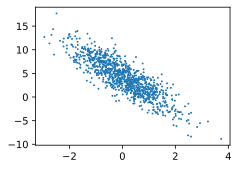

In [55]:
# 线性回归模型：y = w^T X + b
def synthetic_data(w, b, num_examples):
    # 生成y=Xw+b+噪声,噪声遵循正态分布，标准差为0.01
    X = tf.zeros((num_examples, w.shape[0])) # 生成1000个
    X += tf.random.normal(shape=X.shape) # 加上随机数
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

true_w = tf.constant([2, -3.4]) # w^T = [2 -3.4], w.shape = [2]
true_b = 4.2 # b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].numpy(), labels.numpy(), 1)

# 读取数据集，从随机生成的数据中抽取batch_size大小的数据

In [56]:
# 在下面的代码中，我们定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i: min(i + batch_size, num_examples)])
        # gather(tensor, idx) 获取索引为idx，组成新的张量
        yield tf.gather(features, j), tf.gather(labels, j)
    
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[ 0.30995148  0.49962458]
 [ 0.1786894  -1.8981526 ]
 [ 1.7231312   1.4409908 ]
 [-0.37926942  0.26770914]
 [ 1.2549207   0.46467286]
 [ 1.7458649  -0.6199716 ]
 [-1.1253119  -1.7340102 ]
 [ 0.50281364  0.33315748]
 [-0.01946122  2.0090868 ]
 [ 0.2790109   0.07773   ]], shape=(10, 2), dtype=float32) 
 tf.Tensor(
[[ 3.1173522]
 [11.012368 ]
 [ 2.7593744]
 [ 2.5298011]
 [ 5.135153 ]
 [ 9.785084 ]
 [ 7.845668 ]
 [ 4.0785856]
 [-2.6444435]
 [ 4.472154 ]], shape=(10, 1), dtype=float32)


# 初始化模型参数

In [57]:
# 通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0
w = tf.Variable(tf.random.normal(shape=(2, 1), mean = 0, stddev=0.01))
b = tf.Variable(tf.zeros(1), trainable=True)
print("w = ", w)
print("b = ", b)

w =  <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[-0.01621872],
       [ 0.00336704]], dtype=float32)>
b =  <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


# 定义模型，损失函数，优化算法

In [58]:
# 定义模型
def linreg(X, w, b):
    return tf.matmul(X, w) + b

# 定义损失函数
def squared_loss(y_hat, y):
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

# 定义优化算法
def sgd(params, grads, lr, batch_size):
    for param, grad in zip(params, grads):
        param.assign_sub(lr * grad / batch_size)

# 训练

In [59]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

# 自动微分计算梯度
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            l = loss(net(X, w, b), y)
        dw, db = g.gradient(l, [w, b])
        sgd([w, b], [dw, db], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(tf.reduce_mean(train_l)):f}')

print(f'w的估计误差: {true_w - tf.reshape(w, true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

epoch 1, loss 0.046276
epoch 2, loss 0.000183
epoch 3, loss 0.000052
w的估计误差: [ 0.0006181  -0.00109506]
b的估计误差: [0.00136185]
